# Final Project - A Comprehensive Analysis of Model Performance Metrics

### Import necessary libraries

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import brier_score_loss, roc_curve, auc
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from keras.models import Sequential
from keras.layers import Input, LSTM, Dense
from keras.optimizers import Adam

### Metrics Computation Function

In [35]:
def compute_metrics(TP, TN, FP, FN):
    
    # The number of positive examples
    P = TP + FN
    # The number of negative examples
    N = TN + FP
    # True positive rate
    TPR = TP / P if P != 0 else 0 # same as recall/sensitivity
    # True negative rate
    TNR = TN / N if N != 0 else 0 
    # False positive rate
    FPR = FP / N if N != 0 else 0 
    # False negative rate
    FNR = FN / P if P != 0 else 0  
    # Recall or sensitivity
    Recall = TPR
    # Precision
    Precision = TP / (TP + FP) if (TP + FP) != 0 else 0
    # F1 Score
    F1 = 2 * (Precision * Recall) / (Precision + Recall) if (Precision + Recall) != 0 else 0
    # Accuracy
    Accuracy = (TP + TN) / (P + N) if (P + N) != 0 else 0
    # Error rate
    Error = (FP + FN) / (P + N) if (P + N) != 0 else 0
    # Balanced accuracy
    Balanced_Accuracy = (TPR + TNR) / 2
    # True skill statistics
    TSS = TPR - FPR
    # Heidke skill score
    HSS = (2 * (TP * TN - FP * FN)) / ((TP + FN) * (FN + TN) + (TP + FP) * (FP + TN)) if ((TP + FN) * (FN + TN) + (TP + FP) * (FP + TN)) != 0 else 0

    # Store metrics in a dictionary
    metrics = {
        'No. of positive examples (P)': P,
        'No. of negative examples (N)': N,
        'True Positive Rate (TPR)': TPR,
        'True Negative Rate (TNR)': TNR,
        'False Positive Rate (FPR)': FPR,
        'False Negative Rate (FNR)': FNR,
        'Recall (Sensitivity)': Recall,
        'Precision': Precision,
        'F1 Score': F1,
        'Accuracy': Accuracy,
        'Error Rate': Error,
        'Balanced Accuracy': Balanced_Accuracy,
        'TSS': TSS,
        'HSS': HSS,
    }
    
    return metrics

# Computing average metrics across different values of k
def average_metrics(metrics_list):
    average_metrics = {}
    for key in metrics_list[0].keys():
        average_metrics[key] = sum(d[key] for d in metrics_list) / len(metrics_list)
    return average_metrics

### ROC Curve Plot Function

In [36]:
# Computing average ROC data
def avg_roc(fpr_list, tpr_list):
    
    all_fpr = np.concatenate(fpr_list)
    all_tpr = np.concatenate(tpr_list)
    sorted_fpr, sorted_tpr = zip(*sorted(zip(all_fpr, all_tpr)))
    mean_fpr = np.linspace(0, 1, 100)  
    mean_tpr = np.interp(mean_fpr, sorted_fpr, sorted_tpr)
    mean_fpr = np.insert(mean_fpr, 0, 0)
    mean_tpr = np.insert(mean_tpr, 0, 0)
    
    return mean_fpr, mean_tpr

# Individual ROC curve plots 
def plot_roc(fpr_list, tpr_list, auc_list, model_name):

    avg_fpr, avg_tpr = avg_roc(fpr_list, tpr_list)
    avg_auc = np.mean(auc_list)
    plt.plot(avg_fpr, avg_tpr, color = 'purple', label=f"{model_name} (AUC = {avg_auc:.3f})")
    plt.plot([0, 1], [0, 1], color='black', linestyle='--', label="Random Guess")
    plt.legend(loc="lower right")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {model_name}")
    plt.grid() 
    plt.show()

# Combined ROC curve plot
def plot_combined_roc(nb_fpr, nb_tpr, nb_auc, dt_fpr, dt_tpr, dt_auc, rf_fpr, rf_tpr, rf_auc, lstm_fpr, lstm_tpr, lstm_auc):
    
    plt.figure(figsize=(10, 8))
    
    # Naive Bayes
    nb_fpr_avg, nb_tpr_avg = avg_roc(nb_fpr, nb_tpr)
    plt.plot(nb_fpr_avg, nb_tpr_avg, label=f"Naive Bayes (AUC = {np.mean(nb_auc):.2f})", color="blue")
    
    # Decision Tree
    dt_fpr_avg, dt_tpr_avg = avg_roc(dt_fpr, dt_tpr)
    plt.plot(dt_fpr_avg, dt_tpr_avg, label=f"Decision Tree (AUC = {np.mean(dt_auc):.2f})", color="green")
    
    # Random Forest
    rf_fpr_avg, rf_tpr_avg = avg_roc(rf_fpr, rf_tpr)
    plt.plot(rf_fpr_avg, rf_tpr_avg, label=f"Random Forest (AUC = {np.mean(rf_auc):.2f})", color="orange")
    
    # LSTM
    lstm_fpr_avg, lstm_tpr_avg = avg_roc(lstm_fpr, lstm_tpr)
    plt.plot(lstm_fpr_avg, lstm_tpr_avg, label=f"LSTM (AUC = {np.mean(lstm_auc):.2f})", color="red")

    # Adding the random guess line
    plt.plot([0, 1], [0, 1], color='black', linestyle='--', label="Random Guess")
    
    plt.legend(loc="lower right")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Combined ROC Curve")   
    plt.grid()
    plt.show()

### Model 1 - Naive Bayes

In [37]:
# Naive Bayes implementation
def evaluate_naive_bayes(X, y, kfolds=10):
    print("\n\n(1) Naive Bayes\n")
    
    kf = KFold(n_splits=kfolds, shuffle=True, random_state=42)
    metrics_list = []
    fpr_list, tpr_list, auc_list = [], [], []
    
    model = GaussianNB()
    
    # Train-test split
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Training the model 
        model.fit(X_train, y_train)
        
        # Probabilities of positive class
        y_pred_prob = model.predict_proba(X_test)[:, 1]  
        
        # Computing and storing ROC curve metrics
        fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
        roc_auc = auc(fpr, tpr)
        fpr_list.append(fpr)
        tpr_list.append(tpr)
        auc_list.append(roc_auc)
        
        # Prediction
        y_pred = model.predict(X_test)
        
        # Computation of BS and BSS 
        bs = brier_score_loss(y_test, y_pred_prob)
        ref_prob = np.mean(y_test)
        bs_ref = brier_score_loss(y_test, np.full_like(y_test, ref_prob))
        bss = 1 - (bs / bs_ref)

        # Extracting TP, TN, FP, FN from Confusion matrix 
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        metrics = compute_metrics(tp, tn, fp, fn)
        
        # Adding metrics to the list
        metrics['BS'] = bs
        metrics['BSS'] = bss
        metrics['AUC'] = roc_auc  
        metrics_list.append(metrics)
        
        # Reducing column name lengths for formatting
        new_column_names = {
            "No. of positive examples (P)": "P",
            "No. of negative examples (N)": "N",
            "True Positive Rate (TPR)": "TPR",
            "True Negative Rate (TNR)": "TNR",
            "False Positive Rate (FPR)": "FPR",
            "False Negative Rate (FNR)": "FNR",
            "Recall (Sensitivity)": "Recall",
            "Precision": "Precision",
            "F1 Score": "F1 score",
            "Accuracy": "Accuracy",
            "Error Rate": "Error rate",
            "Balanced Accuracy": "BACC",
            "TSS": "TSS",
            "HSS": "HSS",
            "BS": "BS",
            "BSS": "BSS",
            "AUC": "AUC",           
        }
        
    # Printing all metrics for each value of kfold 
    metrics_df = pd.DataFrame(metrics_list)
    metrics_df = metrics_df.round(2)
    metrics_df.rename(columns=new_column_names, inplace=True)
    metrics_df.index = range(1, len(metrics_df) + 1)
    metrics_df.index.name = "k"
    pd.set_option("display.max_columns", None) 
    pd.set_option("display.width", 200)        
    pd.set_option("display.max_rows", None)    
    print(metrics_df)

    return metrics_list, fpr_list, tpr_list, auc_list

### Model 2 - Decision Tree

In [38]:
# Decision Tree Implementation
def evaluate_decision_tree(X, y, kfolds=10):
    print("\n\n(2) Decision Tree\n")
    
    kf = KFold(n_splits=kfolds, shuffle=True, random_state=42)
    metrics_list = []
    fpr_list, tpr_list, auc_list = [], [], []
    
    model = DecisionTreeClassifier(random_state=42)
    
    # Train-test split
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Training the model 
        model.fit(X_train, y_train)
        
        # Probabilities of positive class
        y_pred_prob = model.predict_proba(X_test)[:, 1]  
        
        # Computing and storing ROC curve metrics
        fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
        roc_auc = auc(fpr, tpr)
        fpr_list.append(fpr)
        tpr_list.append(tpr)
        auc_list.append(roc_auc)

        # Prediction
        y_pred = model.predict(X_test)
        
        # Computation of BS and BSS 
        bs = brier_score_loss(y_test, y_pred_prob)
        ref_prob = np.mean(y_test)
        bs_ref = brier_score_loss(y_test, np.full_like(y_test, ref_prob))
        bss = 1 - (bs / bs_ref)
        
        # Extracting TP, TN, FP, FN from Confusion matrix 
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        metrics = compute_metrics(tp, tn, fp, fn)
        
        # Adding metrics to the list
        metrics['BS'] = bs
        metrics['BSS'] = bss
        metrics['AUC'] = roc_auc  
        metrics_list.append(metrics)
        
        # Reducing column name lengths for formatting
        new_column_names = {
            "No. of positive examples (P)": "P",
            "No. of negative examples (N)": "N",
            "True Positive Rate (TPR)": "TPR",
            "True Negative Rate (TNR)": "TNR",
            "False Positive Rate (FPR)": "FPR",
            "False Negative Rate (FNR)": "FNR",
            "Recall (Sensitivity)": "Recall",
            "Precision": "Precision",
            "F1 Score": "F1 score",
            "Accuracy": "Accuracy",
            "Error Rate": "Error rate",
            "Balanced Accuracy": "BACC",
            "TSS": "TSS",
            "HSS": "HSS",
            "BS": "BS",
            "BSS": "BSS",
            "AUC": "AUC",         
        }
    
    # Printing all metrics for each value of kfold
    metrics_df = pd.DataFrame(metrics_list)
    metrics_df = metrics_df.round(2)
    metrics_df.rename(columns=new_column_names, inplace=True)
    metrics_df.index = range(1, len(metrics_df) + 1)
    metrics_df.index.name = "k"
    pd.set_option("display.max_columns", None)  
    pd.set_option("display.width", 200)        
    pd.set_option("display.max_rows", None)   
    print(metrics_df)

    return metrics_list, fpr_list, tpr_list, auc_list

### Model 3 - Random Forest

In [39]:
# Random Forest Implementation
def evaluate_random_forest(X, y, kfolds=10):
    print("\n\n(3) Random Forest\n")
    
    kf = KFold(n_splits=kfolds, shuffle=True, random_state=42)
    metrics_list = []
    fpr_list, tpr_list, auc_list = [], [], []
    model = RandomForestClassifier(random_state=42)
    
    # Train-test split
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Training the model 
        model.fit(X_train, y_train)
        
        # Probabilities of positive class
        y_pred_prob = model.predict_proba(X_test)[:, 1]  # Probabilities for the positive class
        
        # Computing and storing ROC curve metrics
        fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
        roc_auc = auc(fpr, tpr)
        fpr_list.append(fpr)
        tpr_list.append(tpr)
        auc_list.append(roc_auc)

        # Prediction
        y_pred = model.predict(X_test)

        # Computation of BS and BSS 
        bs = brier_score_loss(y_test, y_pred_prob)
        ref_prob = np.mean(y_test)
        bs_ref = brier_score_loss(y_test, np.full_like(y_test, ref_prob))
        bss = 1 - (bs / bs_ref)

        
        # Extracting TP, TN, FP, FN from Confusion matrix 
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        metrics = compute_metrics(tp, tn, fp, fn)
        
        # Add metrics to the list
        metrics['BS'] = bs
        metrics['BSS'] = bss
        metrics['AUC'] = roc_auc
        metrics_list.append(metrics)
        
        # Reducing column name lengths for formatting
        new_column_names = {
            "No. of positive examples (P)": "P",
            "No. of negative examples (N)": "N",
            "True Positive Rate (TPR)": "TPR",
            "True Negative Rate (TNR)": "TNR",
            "False Positive Rate (FPR)": "FPR",
            "False Negative Rate (FNR)": "FNR",
            "Recall (Sensitivity)": "Recall",
            "Precision": "Precision",
            "F1 Score": "F1 score",
            "Accuracy": "Accuracy",
            "Error Rate": "Error rate",
            "Balanced Accuracy": "BACC",
            "TSS": "TSS",
            "HSS": "HSS",
            "BS": "BS",
            "BSS": "BSS",
            "AUC": "AUC",
        }
        
    # Printing all metrics for each value of kfold     
    metrics_df = pd.DataFrame(metrics_list)
    metrics_df = metrics_df.round(2)
    metrics_df.rename(columns=new_column_names, inplace=True)
    metrics_df.index = range(1, len(metrics_df) + 1)
    metrics_df.index.name = "k"
    pd.set_option("display.max_columns", None) 
    pd.set_option("display.width", 200)        
    pd.set_option("display.max_rows", None)    
    print(metrics_df)

    return metrics_list, fpr_list, tpr_list, auc_list

### Model 4 - Long Short-Term Memory (LSTM)

In [40]:
# LSTM Model Implementation
def evaluate_lstm(X, y, kfolds=10):
    print("\n\n\n(4) LSTM")
    
    kf = KFold(n_splits=kfolds, shuffle=True, random_state=42)
    metrics_list = []
    fpr_list, tpr_list, auc_list = [], [], []
    
    print("\nLSTM Training Results: ")
    
    # Train-test split
    for i, (train_index, test_index) in enumerate(kf.split(X)):
        print(f"\n\t------- Fold k = {i + 1} -------") 
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        # Reshaping the data for LSTM
        X_train_lstm = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
        X_test_lstm = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))

        # Building the LSTM model
        model = Sequential()
        model.add(Input(shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
        model.add(LSTM(units=64, activation='relu'))
        model.add(Dense(units=1, activation='sigmoid'))  
        model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
        
        # Train the model and print the loss and accuracy
        history = model.fit(X_train_lstm, y_train, epochs=10, batch_size=32, verbose=0) 
        loss = history.history['loss']
        accuracy = history.history['accuracy']
        for i, (l, acc) in enumerate(zip(loss, accuracy)):
            print(f"Epoch {i+1}: Loss = {l:.4f}, Accuracy = {acc:.4f}")

        # Predicting probabilities
        y_pred_prob = model.predict(X_test_lstm)
        
        # Computing and storing ROC curve metrics
        fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
        roc_auc = auc(fpr, tpr)
        fpr_list.append(fpr)
        tpr_list.append(tpr)
        auc_list.append(roc_auc)

        # Prediction
        y_pred = (model.predict(X_test_lstm) > 0.5).astype(int) 

        # Computation of BS and BSS 
        bs = brier_score_loss(y_test, y_pred_prob)
        ref_prob = np.mean(y_test)
        bs_ref = brier_score_loss(y_test, np.full_like(y_test, ref_prob))
        bss = 1 - (bs / bs_ref)

        
        # Extracting TP, TN, FP, FN from Confusion matrix 
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        metrics = compute_metrics(tp, tn, fp, fn)
        
        # Add metrics to the list
        metrics['BS'] = bs
        metrics['BSS'] = bss
        metrics['AUC'] = roc_auc  # Add AUC to the metrics dictionary
        metrics_list.append(metrics)

        # Reducing column name lengths for formatting
        new_column_names = {
            "No. of positive examples (P)": "P",
            "No. of negative examples (N)": "N",
            "True Positive Rate (TPR)": "TPR",
            "True Negative Rate (TNR)": "TNR",
            "False Positive Rate (FPR)": "FPR",
            "False Negative Rate (FNR)": "FNR",
            "Recall (Sensitivity)": "Recall",
            "Precision": "Precision",
            "F1 Score": "F1 score",
            "Accuracy": "Accuracy",
            "Error Rate": "Error rate",
            "Balanced Accuracy": "BACC",
            "TSS": "TSS",
            "HSS": "HSS",
            "BS": "BS",
            "BSS": "BSS",
            "AUC": "AUC",           
        }
    
    # Printing all metrics for each value of kfold 
    print("\n")
    metrics_df = pd.DataFrame(metrics_list)
    metrics_df = metrics_df.round(2)
    metrics_df.rename(columns=new_column_names, inplace=True)
    metrics_df.index = range(1, len(metrics_df) + 1)
    metrics_df.index.name = "k"
    pd.set_option("display.max_columns", None)  
    pd.set_option("display.width", 200)        
    pd.set_option("display.max_rows", None)    
    print(metrics_df)

    return metrics_list, fpr_list, tpr_list, auc_list

### Driver Function

-------------------------------------------------------------------------------------------------------------------
                      Final Project - A Comprehensive Analysis of Model Performance Metrics                 
-------------------------------------------------------------------------------------------------------------------


TABLE OF CONTENTS:

[I] Introduction
[II] Data Preprocessing and Exploration
[III] Evaluation metrics for all models using KFold Cross Validation (k = 10)
[IV] Comparison of Evaluation Metrics for all four algorithms
[v] ROC Curves for all models


[I] INTRODUCTION

I implemented four different classification algorithms on the Breast Cancer dataset—Naive Bayes, Decision Tree, Random Forest, and LSTM—to evaluate their performance metrics. This dataset predicts whether a tumor is malignant (1) or benign (0) based on 30 features.The metrics analyzed include the number of positive and negative examples, true positive rate (TPR), true negative rate (TNR)

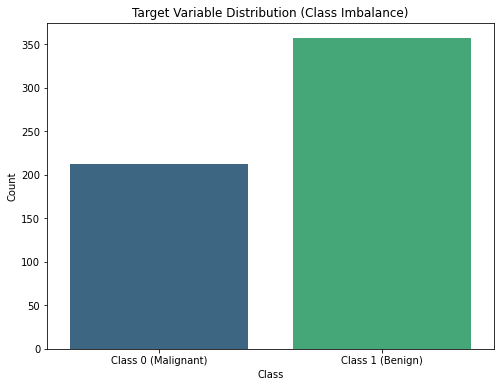


Since there is a class imbalance in the dataset, instead of relying only on accuracy, we need to focus on metrics like precision, recall, F1-score and AUC-ROC


--> Correlation Matrix


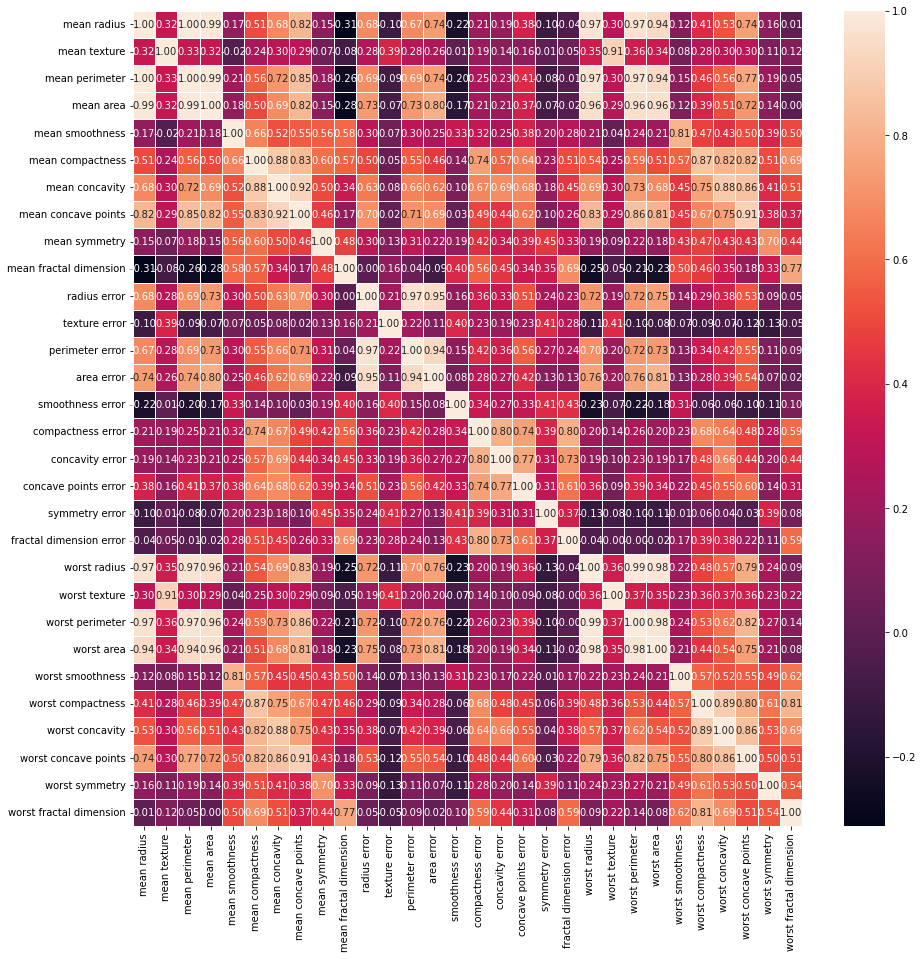




[III] EVALUATION METRICS FOR ALL MODELS USING K-FOLD CROSS VALIDATION (K = 10)


(1) Naive Bayes

     P   N   TPR   TNR   FPR   FNR  Recall  Precision  F1 score  Accuracy  Error rate  BACC   TSS   HSS    BS   BSS   AUC
k                                                                                                                        
1   40  17  0.98  0.94  0.06  0.02    0.98       0.98      0.98      0.96        0.04  0.96  0.92  0.92  0.04  0.95  0.99
2   31  26  1.00  0.92  0.08  0.00    1.00       0.94      0.97      0.96        0.04  0.96  0.92  0.93  0.03  0.94  1.00
3   37  20  0.89  0.85  0.15  0.11    0.89       0.92      0.90      0.88        0.12  0.87  0.74  0.73  0.12  0.81  0.98
4   40  17  0.98  0.94  0.06  0.02    0.98       0.98      0.98      0.96        0.04  0.96  0.92  0.92  0.04  0.95  0.99
5   39  18  0.95  0.89  0.11  0.05    0.95       0.95      0.95      0.93        0.07  0.92  0.84  0.84  0.07  0.90  0.99
6   32  25  0.94  0.96  0.04  0.06    0.94   

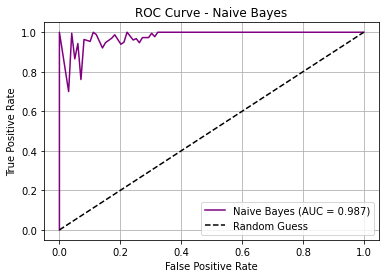

(2) Decision Tree


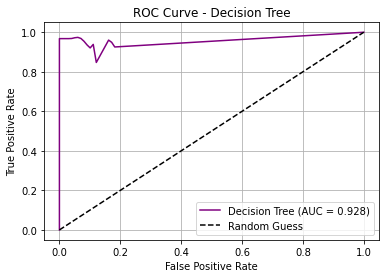

(3) Random Forest


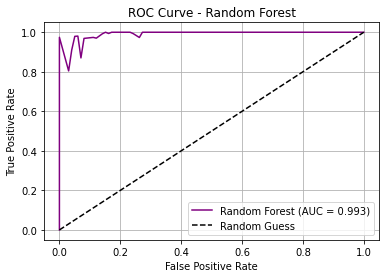

(4) LSTM


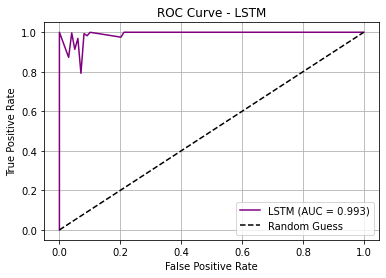

(5) Combined ROC Curve


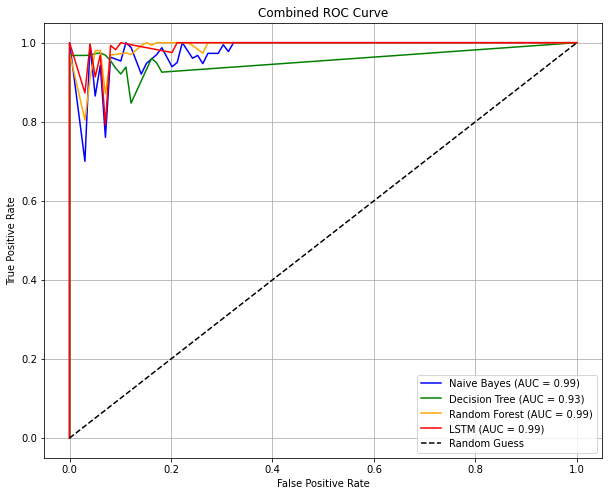




Thank you for running the program! Goodbye!

-------------------------------------------------------------------------------------------------------------------


In [41]:
print("-------------------------------------------------------------------------------------------------------------------")
print("                      Final Project - A Comprehensive Analysis of Model Performance Metrics                 ")
print("-------------------------------------------------------------------------------------------------------------------\n")
print("\nTABLE OF CONTENTS:\n\n[I] Introduction\n[II] Data Preprocessing and Exploration\n[III] Evaluation metrics for all models using KFold Cross Validation (k = 10)\n[IV] Comparison of Evaluation Metrics for all four algorithms\n[v] ROC Curves for all models")
print("\n\n[I] INTRODUCTION\n")
print("I implemented four different classification algorithms on the Breast Cancer dataset—Naive Bayes, Decision Tree, Random Forest, and LSTM—to evaluate their performance metrics. This dataset predicts whether a tumor is malignant (1) or benign (0) based on 30 features.The metrics analyzed include the number of positive and negative examples, true positive rate (TPR), true negative rate (TNR), false positive rate (FPR), false negative rate (FNR), recall (sensitivity), precision, F1 score, accuracy, error rate, balanced accuracy, true skill statistic (TSS), Heidke skill score (HSS), Brier score, Brier skill score (BSS), area under the curve (AUC), and the ROC curve. The project utilizes k-fold cross-validation with k=10 to ensure robust evaluation.")
print("\n\n[II] DATA PREPROCESSING AND EXPLORATION")

# Load the dataset
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target)

# Standardize the features
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Dataset sample
print("\n--> Dataset Sample:\n")
df = pd.concat([X, y], axis=1)
print(df.head())

# General information about the dataset
print("\n--> Dataset General Information:\n")
print( X.info())

# Statistical summary of the dataset
print("\n\n--> Dataset Statistical Information:\n\n", X.describe())

# Count of target labels
class_counts = y.value_counts()
print("\n\n--> Target Variable Split:\n", class_counts)


# Target Variable Distribution (Class Imbalance) Plot
print("\n\n--> Target Variable Distribution Plot")
plt.figure(figsize=(8, 6))
sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")
plt.title("Target Variable Distribution (Class Imbalance)")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(ticks=[0, 1], labels=["Class 0 (Malignant)", "Class 1 (Benign)"])
plt.show()
print("\nSince there is a class imbalance in the dataset, instead of relying only on accuracy, we need to focus on metrics like precision, recall, F1-score and AUC-ROC")

# Correlation matrix 
print("\n\n--> Correlation Matrix")
fig, axis = plt.subplots(figsize=(15, 15))
correlation_matrix = X.corr()
sns.heatmap(correlation_matrix, annot=True, linewidths=.5, fmt='.2f', ax=axis)
plt.show()

print("\n\n\n[III] EVALUATION METRICS FOR ALL MODELS USING K-FOLD CROSS VALIDATION (K = 10)")
# Evaluating each model  
naive_bayes_metrics, nb_fpr, nb_tpr, nb_auc = evaluate_naive_bayes(X_scaled, y)
decision_tree_metrics, dt_fpr, dt_tpr, dt_auc = evaluate_decision_tree(X_scaled, y)
random_forest_metrics, rf_fpr, rf_tpr, rf_auc = evaluate_random_forest(X_scaled, y)
lstm_metrics, lstm_fpr, lstm_tpr, lstm_auc = evaluate_lstm(X_scaled, y)

# Calculating average metrics for all models
naive_bayes_avg_metrics = average_metrics(naive_bayes_metrics)
decision_tree_avg_metrics = average_metrics(decision_tree_metrics)
random_forest_avg_metrics = average_metrics(random_forest_metrics)
lstm_avg_metrics = average_metrics(lstm_metrics)

# Displaying summary for evaluation metrics across models
metrics_table = pd.DataFrame({
    "Naive Bayes": naive_bayes_avg_metrics,
    "Decision Tree": decision_tree_avg_metrics,
    "Random Forest": random_forest_avg_metrics,
    "LSTM": lstm_avg_metrics,
})

print("\n\n[IV] COMPARISON OF EVALUATION METRICS FOR ALL FOUR ALGORITHMS\n")
print(metrics_table.round(4).to_string())


# Plotting ROC for each model
print("\n\n[V] ROC CURVES FOR ALL MODELS\n")
print("(1) Naive Bayes")
plot_roc(nb_fpr, nb_tpr, nb_auc, "Naive Bayes")
print("(2) Decision Tree")
plot_roc(dt_fpr, dt_tpr, dt_auc, "Decision Tree")
print("(3) Random Forest")
plot_roc(rf_fpr, rf_tpr, rf_auc, "Random Forest")
print("(4) LSTM")
plot_roc(lstm_fpr, lstm_tpr, lstm_auc, "LSTM")

# Plotting the combined ROC curve for all models
print("(5) Combined ROC Curve")
plot_combined_roc(nb_fpr, nb_tpr, nb_auc, dt_fpr, dt_tpr, dt_auc, rf_fpr, rf_tpr, rf_auc, lstm_fpr, lstm_tpr, lstm_auc)

print("\n\n\nThank you for running the program! Goodbye!\n")
print("-------------------------------------------------------------------------------------------------------------------")
